In [1]:
suppressPackageStartupMessages({
  library(cowplot)
  library(dataorganizer)
  library(dplyr)
  library(magrittr)
  library(Matrix)
  library(readr)
  library(ggplot2)
  library(Seurat)
  library(sccore)
  library(patchwork)
})

theme_set(theme_bw())

## Load data

In [2]:
cell_annot <- DatasetPath('human_ovarian_cancer_rna', 'FLEX_Ovarian_Barcode_Cluster_Annotation.csv') %>%
  read_csv(show_col_types=FALSE) %$% setNames(`Cell Annotation`, Barcode)

is_doublet <- DatasetPath('human_ovarian_cancer_rna', 'processed', 'doublet_scores.csv') %>%
  read_csv(show_col_types=FALSE) %$% setNames(predicted_doublet, barcode)

In [3]:
so_rna <- DatasetPath('human_ovarian_cancer_rna', '17k_Ovarian_Cancer_scFFPE_count_filtered_feature_bc_matrix.h5') %>%
  Read10X_h5() %>% CreateSeuratObject() %>% subset(cells=names(cell_annot)[!is_doublet[names(cell_annot)]])

so_rna$cell_type <- cell_annot[colnames(so_rna)]

so_rna

An object of class Seurat 
18082 features across 15672 samples within 1 assay 
Active assay: RNA (18082 features, 0 variable features)
 1 layer present: counts

In [4]:
so_rna[["percent.mt"]] <- PercentageFeatureSet(so_rna, pattern = "^MT-")
so_rna %<>% subset(cells=colnames(.)[.$percent.mt < 2])

## Process

In [5]:
so_rna %<>%
  NormalizeData() %>%
  FindVariableFeatures(selection.method="vst", nfeatures=2000) %>%
  ScaleData() %>%
  RunPCA(., features=VariableFeatures(.)) %>%
  FindNeighbors(dims=1:30) %>%
  RunUMAP(dims=1:30, n.epochs=500) %>%
  FindClusters(resolution=2, algorithm=2)

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  VIM, COL6A2, FOSB, KLF6, COL6A1, FN1, TSC22D3, COL6A3, COL3A1, COL1A2 
	   CRISPLD2, THBS2, ZEB2, VCAN, KLF2, STAB1, COL5A1, SRGN, RHOB, CHST11 
	   COL1A1, SAT1, PRKG1, TAGLN, CCN1, RGS1, MS4A7, NR4A3, BTG2, KLF4 
Negative:  HJURP, UBE2C, ITGB8, CIT, NUSAP1, ECT2, CIP2A, SPC24, TPX2, EYA2 
	   SPC25, KIF18B, RECQL4, TOP2A, SMC4, TROAP, POLQ, IQGAP3, AURKB, RAD54L 
	   MAPK15, TONSL, CP, SPAG5, ASPM, CDCA3, KLHL14, KIF2C, NECTIN3, CEP70 
PC_ 2 
Positive:  RGS1, SPI1, CD74, MS4A7, STAB1, CSF1R, SRGN, CD14, ITGAX, ALOX5 
	   SPP1, HSPA6, LAPTM5, C1QC, CIITA, OLR1, CD163, CYBB, SLC11A1, C1QA 
	   MS4A6A, ADAP2, MSR1, C1QB, APOE, CYTH4, FCGR2A, FCGBP, SLCO2B1, TLR2 
Negative:  COL1A1, COL6A2, COL1A2, COL3A1, CCN1, COL6A3, THBS2, COL5A1, COL6A1, CALD1 
	   SPARC, COL16A1, LAMB1, AEBP1, COL5A2, INHBA, CDH11, COL11A1, TPM1, CCN2 
	   NKD2, CRISPLD2, BGN, DCN, CTHRC1, PRK

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15410
Number of edges: 594235

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.8532
Number of communities: 34
Elapsed time: 1 seconds


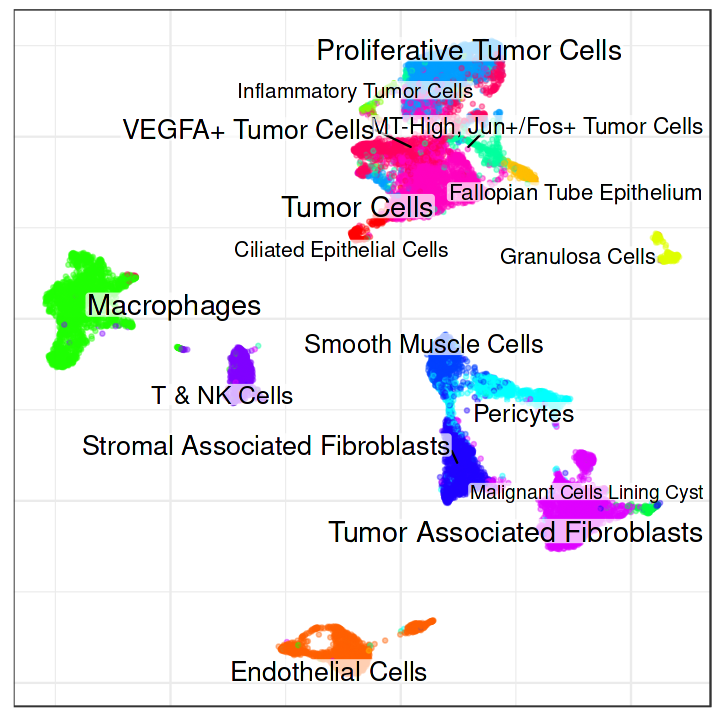

In [6]:
options(repr.plot.width=6, repr.plot.height=6)
embeddingPlot(so_rna, 'umap', groups='cell_type', font.size=c(4, 6))

In [7]:
so_rna$cell_type_full <- so_rna$cell_type
so_rna$cell_type[grep('Tumor Cells', so_rna$cell_type)] <- 'Tumor Cells'

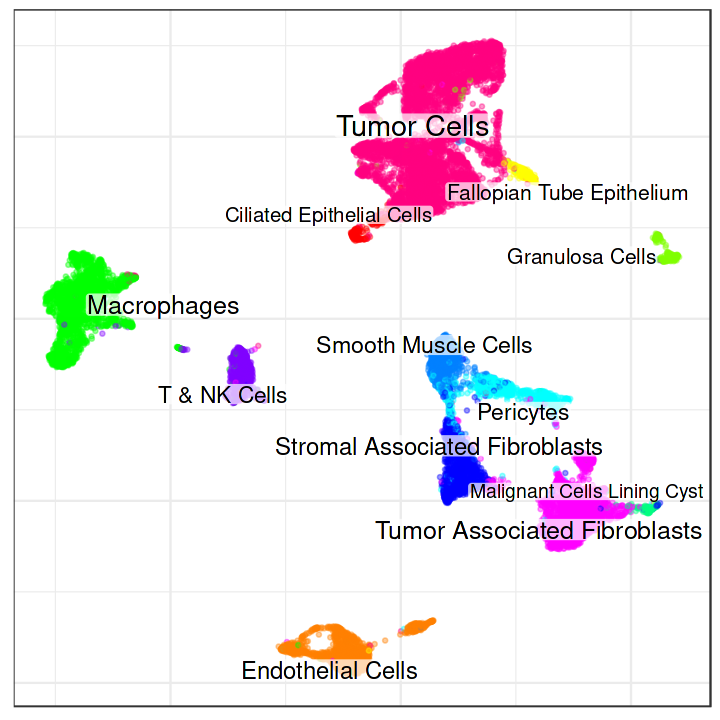

In [8]:
options(repr.plot.width=6, repr.plot.height=6)
embeddingPlot(so_rna, 'umap', groups='cell_type', font.size=c(4, 6))

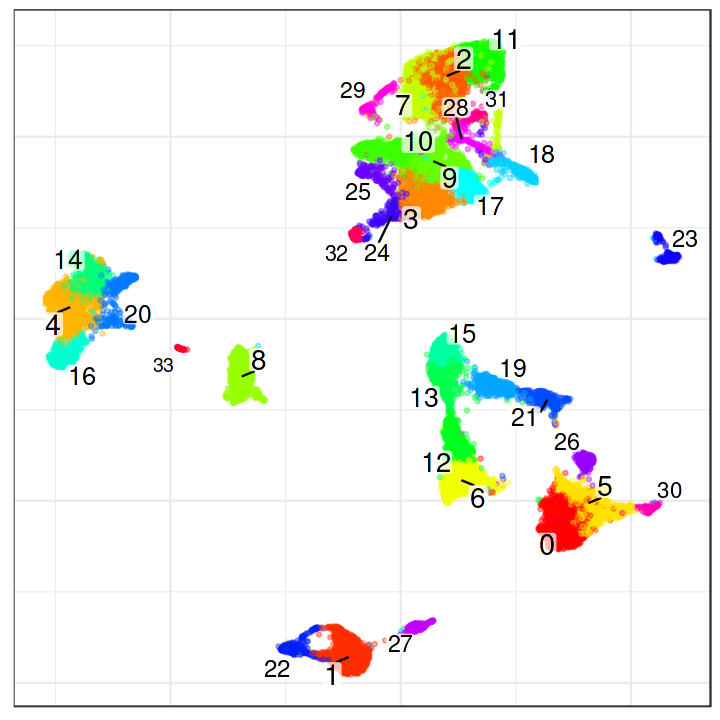

In [25]:
embeddingPlot(so_rna, 'umap', groups='seurat_clusters', font.size=c(4, 6))

Remove small clusters with multiple cell types in them, which are likely doublets:

In [27]:
ct_table <- table(so_rna$seurat_clusters, so_rna$cell_type)

rownames(ct_table) %>% setNames(., .) %>% lapply(\(i) {
    ct_table[i,] %>% .[. > 0] %>% {. / sum(.)} %>% round(2) %>% .[. > 0.1]
})

$`0`
Tumor Associated Fibroblasts 
                        0.99 

$`1`
Endothelial Cells 
             0.99 

$`2`
Tumor Cells 
       0.99 

$`3`
Tumor Cells 
       0.99 

$`4`
Macrophages 
       0.99 

$`5`
Tumor Associated Fibroblasts 
                        0.98 

$`6`
Stromal Associated Fibroblasts 
                          0.93 

$`7`
Tumor Cells 
       0.99 

$`8`
T & NK Cells 
        0.96 

$`9`
Tumor Cells 
          1 

$`10`
Tumor Cells 
       0.99 

$`11`
Tumor Cells 
          1 

$`12`
Stromal Associated Fibroblasts 
                          0.88 

$`13`
          Pericytes Smooth Muscle Cells 
               0.21                0.77 

$`14`
Macrophages 
          1 

$`15`
Smooth Muscle Cells 
               0.99 

$`16`
Macrophages 
          1 

$`17`
Tumor Cells 
          1 

$`18`
Fallopian Tube Epithelium               Tumor Cells 
                     0.74                      0.22 

$`19`
Pericytes 
     0.88 

$`20`
Macrophages 
       0.93 

$`21`
Pericytes 
     0.98 

$`22`
Endothelial Cells 
             0.99 

$`23`
Granulosa Cells 
           0.98 

$`24`
Ciliated Epithelial Cells               Tumor Cells 
                     0.38                      0.61 

$`25`
Tumor Cells 
       0.98 

$`26`
Tumor Associated Fibroblasts 
                           1 

$`27`
Endothelial Cells 
             0.98 

$`28`
Tumor Cells 
       0.94 

$`29`
Tumor Cells 
       0.98 

$`30`
   Malignant Cells Lining Cyst Stromal Associated Fibroblasts 
                          0.71                           0.11 

$`31`
Tumor Cells 
       0.99 

$`32`
Ciliated Epithelial Cells 
                        1 

$`33`
 Macrophages T & NK Cells 
        0.66         0.34

In [30]:
so_rna %<>% subset(cells=names(.$seurat_clusters)[!(.$seurat_clusters %in% c(33))])

In [29]:
so_rna$cell_type[so_rna$seurat_clusters == 30] <- 'Malignant Cells Lining Cyst'

## Save

In [31]:
DatasetPath('human_ovarian_cancer_rna', 'processed', 'so.rds') %>% write_rds(so_rna, .)